In [1]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
clean_hin_dataset = open("datasets\cleaned_hinenglish.txt").read().splitlines()

In [3]:
#building the mappings like tokeniser

clean = sorted(set(''.join(clean_hin_dataset)))
stoi = {s:i for i,s in enumerate(clean)}
stoi['.'] = 27
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
data_size = len(clean_hin_dataset)
hidden_size = 300


In [4]:
# Convert all text into a single string
full_text = ' '.join(clean_hin_dataset)
full_text_idx = [stoi[ch] for ch in full_text]  # Convert to indices

seq_length = 50  # sliding window size
Xtrain, Ytrain = [], []

for i in range(len(full_text_idx) - seq_length):
    Xtrain.append(full_text_idx[i : i + seq_length])
    Ytrain.append(full_text_idx[i + 1 : i + seq_length + 1])

Xtrain = torch.tensor(Xtrain, dtype=torch.long)
Ytrain = torch.tensor(Ytrain, dtype=torch.long)

print("Xtrain shape:", Xtrain.shape)  # (num_examples, 25)
print("Ytrain shape:", Ytrain.shape)  # (num_examples, 25)

Xtrain shape: torch.Size([131374, 50])
Ytrain shape: torch.Size([131374, 50])


In [5]:
g = torch.Generator().manual_seed(2347243647 + 10)
Wxh = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whh = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)
Why = torch.randn((vocab_size, hidden_size), generator=g) * 0.01  # (28,100)
bh = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
by = torch.zeros((vocab_size, 1)) # output bias (28,1)
parameters = [Wxh, Whh, Why, bh, by]
count = 0

for p in parameters:
    count += p.nelement();
count

107128

In [6]:
for p in parameters:
    p.requires_grad = True  # Enable gradient tracking for all parameters

In [7]:
steps, lossi = [], []

In [10]:
X.shape, Y.shape

NameError: name 'X' is not defined

In [48]:
idx = torch.randint(0, len(Xtrain), (1,))


X= Xtrain[idx[0]]
Y = Ytrain[idx[0]]


X, Y

(tensor([ 1,  9,  0,  9, 14,  0,  4,  5,  7, 18,  5,  5, 19,  0,  3,  0,  1, 10,
          0, 11,  9, 20, 14,  9,  0]),
 tensor([ 9,  0,  9, 14,  0,  4,  5,  7, 18,  5,  5, 19,  0,  3,  0,  1, 10,  0,
         11,  9, 20, 14,  9,  0,  7]))

In [33]:
seq_length = 50
batch_size = 1
xs, hs, ys, ps = {}, {}, {}, {}
# X = Xtrain[0]   #25
# Y = Ytrain[0] #25

#initialise hprev to zeros
hs[-1] = torch.zeros((hidden_size, 1))
for i in range(20000):
   idx = torch.randint(0, len(Xtrain), (1,))

   X = Xtrain[idx[0]]
   Y = Ytrain[idx[0]]
   loss = 0
#--------------------------------------------------------------------Forward Pass------------------------------------------#
   for t in range(seq_length):
      xs[t] = torch.zeros((vocab_size, 1))  # one-hot encoding (28,1)
      xs[t][X[t]] = 1  # set the index to 1   
      hs[t] = torch.tanh(Wxh @ xs[t] + Whh @ hs[t-1] + bh) #(100,1) 
      ys[t] = Why @ hs[t] + by  # logits (28,1) 
      loss = loss + f.cross_entropy(ys[t].T, torch.tensor([Y[t]]))  #loss(acculamulated) is sequence wise as all the predictions should be right, also weights are shared across the sequence
      ps[t] = f.softmax(ys[t], dim=0)  # normalized logits (28,1
#--------------------------------------------------------------------backward pass------------------------------------------#
   loss = loss / (seq_length* batch_size)  # average loss over the sequence length
   
   perplexity = torch.exp(loss)  # calculate perplexity
   
   for p in parameters:
      p.grad = None
   loss.backward()

   torch.nn.utils.clip_grad_norm_(parameters, 5)

   
   # Update parameters using gradient descent
   lr = 0.001  # learning rate
   for p in parameters:
      p.data -= lr * p.grad


   steps.append(i)
   lossi.append(loss.item())

    # Detach hidden state for next iteration
   hs[-1] = torch.zeros((hidden_size, 1))


   if i % 1000 == 0:
      print(f"Perplexity at step {i}: {perplexity.item()}")
      print(f"Step {i}, Loss: {loss.item()}")

print(f"Final loss: {loss.item()}")

Perplexity at step 0: 17.610389709472656
Step 0, Loss: 2.8684890270233154
Perplexity at step 1000: 15.682793617248535
Step 1000, Loss: 2.7525641918182373
Perplexity at step 2000: 14.09642219543457
Step 2000, Loss: 2.645920991897583
Perplexity at step 3000: 19.41452980041504
Step 3000, Loss: 2.966021776199341
Perplexity at step 4000: 14.232282638549805
Step 4000, Loss: 2.655512809753418
Perplexity at step 5000: 14.794201850891113
Step 5000, Loss: 2.694235324859619
Perplexity at step 6000: 20.124713897705078
Step 6000, Loss: 3.001948595046997
Perplexity at step 7000: 13.916178703308105
Step 7000, Loss: 2.633052110671997
Perplexity at step 8000: 15.308173179626465
Step 8000, Loss: 2.728386878967285
Perplexity at step 9000: 11.654751777648926
Step 9000, Loss: 2.455713987350464
Perplexity at step 10000: 13.455916404724121
Step 10000, Loss: 2.599418878555298
Perplexity at step 11000: 13.217412948608398
Step 11000, Loss: 2.5815351009368896
Perplexity at step 12000: 12.508013725280762
Step 120

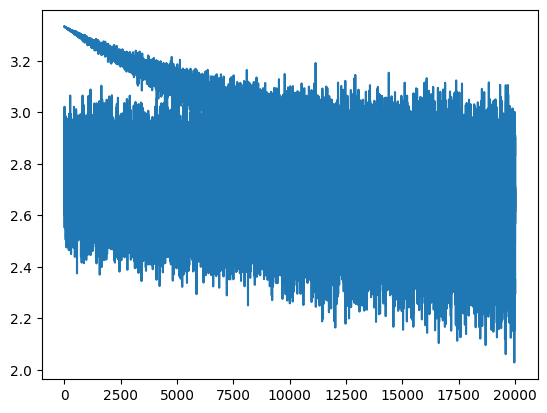

In [38]:
plt.plot(steps, lossi)

In [126]:
print(Wxh.grad.max(), Wxh.grad.min())

tensor(0.) tensor(0.)


In [34]:
def sample(seed_idx, length):
    h = torch.zeros(hidden_size, 1)
    x = torch.zeros(vocab_size, 1)
    x[seed_idx] = 1
    output = []
    for t in range(length):
        h = torch.tanh(Wxh @ x + Whh @ h + bh)
        y = Why @ h + by
        p = f.softmax(y, dim=0)
        idx = torch.multinomial(p.view(-1), 1).item()
        x = torch.zeros(vocab_size, 1)
        x[idx] = 1
        output.append(idx)
    return output


In [45]:
sample_text = sample(seed_idx=stoi['.'], length=50)
sample_text_str = ''.join(itos[idx] for idx in sample_text)

In [46]:
sample_text_str

' taioe kaubgrrie roafresj  lae saoka emiufatoriya '

In [87]:
Xtrain[0]

tensor([ 1, 13,  0, 11, 15,  0, 19, 21, 14,  4,  1, 25,  0,  2, 18, 21, 14,  3,
         8,  0, 11,  5,  0, 12,  9, 25,  5,  0,  5, 11,  0, 14,  1, 25,  1,  0,
        23,  5,  5, 11, 12, 25,  0, 18,  5, 13,  9, 14,  4,  5])

In [ ]:
stoi[Xtrain[0].item()]

KeyError: tensor([ 1, 13,  0, 11, 15,  0, 19, 21, 14,  4,  1, 25,  0,  2, 18, 21, 14,  3,
         8,  0, 11,  5,  0, 12,  9])